In [31]:
# pip install tqdm

In [13]:
# pip install selenium

In [19]:
# pip install requests beautifulsoup4 pandas tqdm

In [ ]:
# 첫번째 시도 코드

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta

# 검색 키워드 및 기간 설정
keyword = "전쟁"
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

def get_news_urls(keyword, date):
    url = f"https://search.naver.com/search.naver?where=news&query=%EC%A0%84%EC%9F%81&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds=2024.04.20&de=2024.05.20&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom20240420to20240520&is_sug_officeid=0&office_category=0&service_area=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

def get_news_content(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    title = soup.select_one("#articleTitle").text.strip()
    content = soup.select_one("#articleBodyContents").text.strip()
    return title, content

news_data = []
date = start_date

while date <= end_date:
    date_str = date.strftime("%Y.%m.%d")
    news_urls = get_news_urls(keyword, date_str)
    for news_url in news_urls:
        try:
            title, content = get_news_content(news_url)
            news_data.append({"date": date_str, "title": title, "content": content, "url": news_url})
        except Exception as e:
            print(f"Failed to crawl {news_url}: {e}")
    date += timedelta(days=1)

df = pd.DataFrame(news_data)
df.to_csv("naver_news.csv", index=False, encoding='utf-8-sig')

In [ ]:
# 두번재 시도 코드

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time

# 검색 기간 설정
start_date = "2024.04.20"
end_date = "2024.05.20"
query = "전쟁"

# URL 템플릿
url_template = ("https://search.naver.com/search.naver"
                "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                "&is_sug_officeid=0&office_category=0&service_area=0")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# 기사 URL 수집 함수
def get_news_urls(page):
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', '')) + f"&start={page}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

# 기사 내용 수집 함수
def get_news_content(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one("#articleTitle")
        content = soup.select_one("#articleBodyContents")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        print(f"Failed to crawl {url}: {e}")
    return None, None

news_data = []

# 네이버 뉴스는 페이지당 10개의 기사를 표시하므로, 10페이지씩 증가시키며 URL을 수집합니다.
page = 1
while True:
    news_urls = get_news_urls(page)
    if not news_urls:
        break
    for news_url in news_urls:
        title, content = get_news_content(news_url)
        if title and content:
            news_data.append({"date": datetime.now().strftime("%Y-%m-%d"), "title": title, "content": content, "url": news_url})
    page += 10
    time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# DataFrame으로 변환 후 CSV로 저장
df = pd.DataFrame(news_data)
df.to_csv("naver_news_war.csv", index=False, encoding='utf-8-sig')

In [2]:
# 세번째 시도 코드
# 크롤링 진행 상황을 터미널에 표시

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time
from tqdm import tqdm

# 검색 기간 설정
start_date = "2024.04.20"
end_date = "2024.05.20"
query = "전쟁"

# URL 템플릿
url_template = ("https://search.naver.com/search.naver"
                "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                "&is_sug_officeid=0&office_category=0&service_area=0")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# 기사 URL 수집 함수
def get_news_urls(page):
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', '')) + f"&start={page}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

# 기사 내용 수집 함수
def get_news_content(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one("#articleTitle")
        content = soup.select_one("#articleBodyContents")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        print(f"Failed to crawl {url}: {e}")
    return None, None

news_data = []
total_pages = 100  # 네이버 뉴스 검색 결과는 100페이지까지 표시됨
page = 1

with tqdm(total=total_pages) as pbar:
    while page <= total_pages:
        news_urls = get_news_urls(page)
        if not news_urls:
            break
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            if title and content:
                news_data.append({"date": datetime.now().strftime("%Y-%m-%d"), "title": title, "content": content, "url": news_url})
        page += 10
        pbar.update(1)
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# DataFrame으로 변환 후 CSV로 저장
df = pd.DataFrame(news_data)
df.to_csv("naver_news_war.csv", index=False, encoding='utf-8-sig')

  6%|████▊                                                                           | 6/100 [03:27<1:01:09, 39.04s/it]

Failed to crawl https://www.asiae.co.kr/: HTTPSConnectionPool(host='www.asiae.co.kr', port=443): Read timed out.


 10%|████████                                                                         | 10/100 [05:50<52:33, 35.03s/it]


In [4]:
# 네번째 시도

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import logging
import time

# 로깅 설정
logging.basicConfig(filename='crawler.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 함수로 크롤링 작업 분리
def get_news_urls(query, start_date, end_date, page):
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                    "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                    "&is_sug_officeid=0&office_category=0&service_area=0")
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', '')) + f"&start={page}"
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

def get_news_content(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one("#articleTitle")
        content = soup.select_one("#articleBodyContents")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    return None, None

# 크롤링 설정
query = "전쟁"
start_date = "2024.04.20"
end_date = "2024.05.20"
total_pages = 100  # 네이버 뉴스 검색 결과는 100페이지까지 표시됨

# 크롤링 진행 상태 표시
with tqdm(total=total_pages) as pbar:
    news_data = []
    page = 1
    while page <= total_pages:
        news_urls = get_news_urls(query, start_date, end_date, page)
        if not news_urls:
            break
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        page += 10
        pbar.update(1)
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# 데이터프레임으로 변환 후 CSV로 저장
df = pd.DataFrame(news_data)
output_file = "naver_news_war.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"크롤링 완료: {output_file}")

 10%|███████▉                                                                       | 10/100 [09:03<1:21:28, 54.32s/it]


In [ ]:
# 5번째 시도

from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import time

# Chrome 실행 파일의 경로를 지정하여 webdriver.Chrome() 호출
driver = webdriver.Chrome("C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe")

# 뉴스 제목과 URL을 저장할 리스트
news_list = []

# 페이지 스크롤을 더 이상 이동하지 않을 때까지 루프하며 실행
scroll_height = 0
while True:
    # 현재 페이지의 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 뉴스 제목과 URL 추출
    for item in soup.select("a.news"):
        title = item.find("div", class_="news_tit").text.strip()
        url = item['href']
        news_list.append({"title": title, "url": url})
    
    # 스크롤 다운
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    
    # 스크롤 위치 확인
    new_scroll_height = driver.execute_script("return document.body.scrollHeight")
    if new_scroll_height == scroll_height:
        break
    scroll_height = new_scroll_height

    # 진행 상황 출력
    if len(news_list) % 10 == 0:
        print(f"진행 상황: {len(news_list)} 개의 뉴스 수집 완료")

# 데이터프레임으로 변환하여 pickle 파일로 저장
df = pd.DataFrame(news_list)
df.to_pickle("news_data.pkl")

# 크롬 드라이버 종료
driver.quit()

# 저장한 pickle 파일 불러오기
df = pd.read_pickle("news_data.pkl")

# CSV로 저장
df.to_csv("news_data.csv", index=False, encoding='utf-8-sig')

In [ ]:
# 6번째 시도

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# 크롤링할 URL
url = "https://search.naver.com/search.naver?where=news&query=전쟁&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds=2024.04.20&de=2024.05.20&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from20240420to20240520&is_sug_officeid=0&office_category=0&service_area=0"

# HTTP 요청을 보내고 응답을 받아옴
response = requests.get(url)
response.raise_for_status()

# 응답 받은 HTML을 BeautifulSoup을 사용하여 파싱
soup = BeautifulSoup(response.text, "html.parser")

# 뉴스 기사 제목과 URL 추출
news_titles = []
news_urls = []
for item in soup.select("a.news"):
    title = item.find("div", class_="news_tit").text.strip()
    url = item['href']
    news_titles.append(title)
    news_urls.append(url)

# 추출한 데이터를 데이터프레임으로 변환
df = pd.DataFrame({"Title": news_titles, "URL": news_urls})

# 데이터프레임을 CSV 파일로 저장
df.to_csv("news_data.csv", index=False, encoding='utf-8-sig')

import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("naver_news_war.csv")

# 데이터 확인
print(df.head())

In [17]:
# 7번째 시도

import requests
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import time

# 뉴스 제목과 URL을 저장할 리스트
news_list = []

# 페이지 스크롤을 더 이상 이동하지 않을 때까지 루프하며 실행
scroll_height = 0
while True:
    # HTTP GET 요청
    response = requests.get("https://search.naver.com/search.naver?where=news&query=%EC%A0%84%EC%9F%81&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds=2024.04.20&de=2024.05.20&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom20240420to20240520&is_sug_officeid=0&office_category=0&service_area=0")
    response.raise_for_status()  # 오류 발생 시 예외 발생

    # BeautifulSoup 객체 생성
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # 뉴스 제목과 URL 추출
    for item in soup.select("a.news"):
        title = item.find("div", class_="news_tit").text.strip()
        url = item['href']
        news_list.append({"title": title, "url": url})
    
    # 스크롤 다운
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    
    # 스크롤 위치 확인
    new_scroll_height = driver.execute_script("return document.body.scrollHeight")
    if new_scroll_height == scroll_height:
        break
    scroll_height = new_scroll_height

    # 진행 상황 출력
    if len(news_list) % 10 == 0:
        print(f"진행 상황: {len(news_list)} 개의 뉴스 수집 완료")

# 수집한 데이터를 pickle 파일로 저장
with open("news_data.pkl", "wb") as f:
    pickle.dump(news_list, f)

# 저장한 pickle 파일 불러오기
with open("news_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# 데이터프레임으로 변환
df = pd.DataFrame(loaded_data)

# CSV로 저장
df.to_csv("news_data.csv", index=False, encoding='utf-8-sig')

NameError: name 'driver' is not defined

In [18]:
# 8번째 시도: 드라이브 포기

import requests
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import logging
import time

# 로깅 설정
logging.basicConfig(filename='crawler.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 함수로 크롤링 작업 분리
def get_news_urls(query, start_date, end_date, page):
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                    "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                    "&is_sug_officeid=0&office_category=0&service_area=0")
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', '')) + f"&start={page}"
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

def get_news_content(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one("#articleTitle")
        content = soup.select_one("#articleBodyContents")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    return None, None

# 크롤링 설정
query = "전쟁"
start_date = "2024.04.20"
end_date = "2024.05.20"
total_pages = 100  # 네이버 뉴스 검색 결과는 100페이지까지 표시됨

# 크롤링 진행 상태 표시
progress_interval = 10
with tqdm(total=total_pages // progress_interval) as pbar:
    news_data = []
    page = 1
    while page <= total_pages:
        news_urls = get_news_urls(query, start_date, end_date, page)
        if not news_urls:
            break
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        page += 10
        if page % progress_interval == 0:
            pbar.update(1)
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# 데이터프레임으로 변환 후 pickle로 저장
output_file_pickle = "news_data.pkl"
with open(output_file_pickle, "wb") as f:
    pickle.dump(news_data, f)
logging.info(f"크롤링 완료: {output_file_pickle}")

# 저장한 pickle 파일 불러오기
with open(output_file_pickle, "rb") as f:
    loaded_data = pickle.load(f)

# 데이터프레임으로 변환 후 CSV로 저장
df = pd.DataFrame(loaded_data)
output_file_csv = "naver_news_war.csv"
df.to_csv(output_file_csv, index=False, encoding='utf-8-sig')
logging.info(f"CSV 파일 저장 완료: {output_file_csv}")

  0%|                                                                                           | 0/10 [05:01<?, ?it/s]


In [21]:
# 9번째 시도

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import logging
import pickle
import time

# 로깅 설정
logging.basicConfig(filename='crawler.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 함수로 크롤링 작업 분리
def get_news_urls(query, start_date, end_date, page):
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                    "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                    "&is_sug_officeid=0&office_category=0&service_area=0")
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', '')) + f"&start={page}"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

def get_news_content(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one("#articleTitle")
        content = soup.select_one("#articleBodyContents")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    return None, None

# 크롤링 설정
query = "전쟁"
start_date = "2024.04.20"
end_date = "2024.05.20"
total_pages = 100  # 네이버 뉴스 검색 결과는 100페이지까지 표시됨

# 크롤링 진행 상태 표시
with tqdm(total=total_pages) as pbar:
    news_data = []
    page = 1
    while page <= total_pages:
        news_urls = get_news_urls(query, start_date, end_date, page)
        if not news_urls:
            break
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        page += 10
        pbar.update(1)
        if len(news_data) % 10 == 0:
            print(f"진행 상황: {len(news_data)} 개의 뉴스 수집 완료")
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# 데이터프레임으로 변환 후 pickle 파일로 저장
df = pd.DataFrame(news_data)
with open("news_data.pkl", "wb") as f:
    pickle.dump(df, f)

# 저장한 pickle 파일 불러오기
with open("news_data.pkl", "rb") as f:
    loaded_df = pickle.load(f)

# CSV로 저장
output_file = "naver_news_war.csv"
loaded_df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"크롤링 완료: {output_file}")


  1%|▊                                                                               | 1/100 [00:46<1:17:20, 46.87s/it]

진행 상황: 0 개의 뉴스 수집 완료


  2%|█▌                                                                              | 2/100 [01:38<1:21:35, 49.95s/it]

진행 상황: 0 개의 뉴스 수집 완료


  3%|██▍                                                                             | 3/100 [02:26<1:18:38, 48.65s/it]

진행 상황: 0 개의 뉴스 수집 완료


  4%|███▏                                                                            | 4/100 [03:14<1:17:27, 48.41s/it]

진행 상황: 0 개의 뉴스 수집 완료


  5%|████                                                                            | 5/100 [03:54<1:12:12, 45.60s/it]

진행 상황: 0 개의 뉴스 수집 완료


  6%|████▊                                                                           | 6/100 [04:40<1:11:47, 45.82s/it]

진행 상황: 0 개의 뉴스 수집 완료


  6%|████▊                                                                           | 6/100 [05:14<1:22:12, 52.48s/it]


KeyboardInterrupt: 

In [29]:
# 10번째 시도 (성공)

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import logging
import pickle
import time

# 로깅 설정
logging.basicConfig(filename='crawler.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 함수로 크롤링 작업 분리
def get_news_urls(query, start_date, end_date, page):
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3"
                    "&ds={start_date}&de={end_date}&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date}"
                    "&is_sug_officeid=0&office_category=0&service_area=0&start={page}")
    url = url_template.format(query=query, start_date=start_date.replace('.', ''), end_date=end_date.replace('.', ''), page=page)
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    return urls

def get_news_content(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one(".media_end_head_headline")
        content = soup.select_one("#dic_area")
        if title and content:
            return title.text.strip(), content.text.strip()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    return None, None

# 크롤링 설정
query = "전쟁"
start_date = "2024.04.20"
end_date = "2024.05.20"
total_pages = 100  # 네이버 뉴스 검색 결과는 100페이지까지 표시됨

# 크롤링 진행 상태 표시
with tqdm(total=total_pages) as pbar:
    news_data = []
    page = 1
    while page <= total_pages * 10:  # 네이버는 페이지당 10개씩 뉴스가 표시됨
        news_urls = get_news_urls(query, start_date, end_date, page)
        if not news_urls:
            break
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        page += 10
        pbar.update(1)
        if len(news_data) % 10 == 0:
            print(f"진행 상황: {len(news_data)} 개의 뉴스 수집 완료")
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

# 데이터프레임으로 변환 후 pickle 파일로 저장
df = pd.DataFrame(news_data)
with open("news_data.pkl", "wb") as f:
    pickle.dump(df, f)

# 저장한 pickle 파일 불러오기
with open("news_data.pkl", "rb") as f:
    loaded_df = pickle.load(f)

# CSV로 저장
output_file = "naver_news_war.csv"
loaded_df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"크롤링 완료: {output_file}")

  1%|▊                                                                                 | 1/100 [00:20<34:26, 20.87s/it]

진행 상황: 10 개의 뉴스 수집 완료


  1%|▊                                                                                 | 1/100 [00:25<42:13, 25.59s/it]


KeyboardInterrupt: 

In [52]:
import pandas as pd
import pickle

# CSV 파일 로드
input_file = r"C:\Users\jkl12\개인적 활동\naver_news_war.csv"
df = pd.read_csv(input_file)

# 긴 문자열을 줄이는 함수 정의
def shorten_text(text, length=20):
    if len(text) > length:
        return text[:length] + '...'
    return text

# 데이터프레임 정리
# 예: 'date', 'title', 'content' 컬럼만 선택하고 'date' 컬럼을 기준으로 정렬
df_cleaned = df[['date', 'title', 'content']].sort_values(by='date')

# 문자열 길이를 줄임
df_cleaned['title'] = df_cleaned['title'].apply(shorten_text)
df_cleaned['content'] = df_cleaned['content'].apply(shorten_text)

# 정리된 데이터프레임 출력
print(df_cleaned.head())
print(df_cleaned.tail())

                  date                    title                  content
0  2024-05-20 23:45:11  "전쟁 범죄 저질렀다"…ICC, 네타...  18일(현지시간) 가자지구 가자시티에...
1  2024-05-20 23:45:12  美국방 "우크라 전쟁, 향후 몇주가 ...  우크라이나 국방연락그룹 22차 회의"...
2  2024-05-20 23:45:13  "경매 나서고, B급 들이고"…인플레...  [앵커]요즘 집에서 먹을 과일 하나를...
3  2024-05-20 23:45:15         [정동칼럼]전쟁에 반대할 자유  | 권혁범 대전대 정치외교학과 명예교...
4  2024-05-20 23:45:16  [World & Now] 미중 관세전...  G2 무역전쟁, 韓에 유탄 우려민관 ...
                    date                    title                  content
693  2024-05-21 01:01:21  "삼성도 서두른다"…유리기판 전쟁 '...  <기자>반도체를 둘러싼 삼성과 SK의...
694  2024-05-21 01:01:27  [Focus TV] 예측불허 MZ돌싱...  MBN의 간판 연애 예능 ‘돌싱글즈5...
695  2024-05-21 01:01:35  정부 지원으로 독일 최초 '6·25전...  베를린 독일 적십자사 본부서 8일 오...
696  2024-05-21 01:01:42         다시 노골화되는 이란 핵 도박  지난 5월 6일 이란 수도 테헤란을 ...
697  2024-05-21 01:01:47  민간 경제학자 출신, 전쟁 중인 러시...  블라디미르 푸틴 러시아 대통령이 세르...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import font_manager, rc
import os

# 나눔고딕 폰트 설정
font_path = r'C:\Users\jkl12\OneDrive\바탕 화면\내 파일\폰트\nanum-all\나눔 글꼴\나눔스퀘어네오\NanumSquareNeo-aLt.ttf'

# 폰트 경로 확인
if not os.path.exists(font_path):
    raise FileNotFoundError(f"폰트 파일을 찾을 수 없습니다: {font_path}")

font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터 로드
file_path = "C:/Users/jkl12/개인적 활동/naver_news_war.csv"
df = pd.read_csv(file_path)

# 'date' 컬럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 기사 제목과 내용에서 많이 언급된 단어
# 모든 제목과 내용을 하나의 문자열로 결합
text = ' '.join(df['title']) + ' ' + ' '.join(df['content'])

# WordCloud 생성 및 시각화
# wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('')
# plt.show()

In [8]:
# pip install pandas matplotlib seaborn wordcloud

In [ ]:
# C:\Users\jkl12\OneDrive\바탕 화면\내 파일\폰트\nanum-all\나눔 글꼴\나눔스퀘어네오\NanumSquareNeo-aLt.ttf

In [16]:
# pip install selenium webdriver-manager

In [4]:
# 기사 수 수집

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

def get_total_news_count(query, start_date, end_date):
    search_url = f"https://search.naver.com/search.naver?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={start_date}&de={end_date}&nso=so%3Ar%2Cp%3Afrom{start_date.replace('.', '')}to{end_date.replace('.', '')}"

    # Selenium 설정
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # 크롤러 실행 시 브라우저가 뜨지 않도록 설정
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(search_url)

    prev_scroll_height = 0
    total_news_count = 0

    while True:
        # 스크롤 내리기
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
        time.sleep(2)  # 페이지 로딩 대기

        # 현재 스크롤 위치
        curr_scroll_height = driver.execute_script("return document.body.scrollHeight")

        # 이전 스크롤 위치와 현재 스크롤 위치 비교
        if curr_scroll_height == prev_scroll_height:
            break  # 더 이상 스크롤할 필요 없음

        prev_scroll_height = curr_scroll_height

        # 현재 페이지의 기사 수
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        news_count = len(soup.select("a.info"))

        total_news_count += news_count

        # 10개씩 증가할 때마다 표시
        if news_count % 10 == 0:
            print(f"현재까지 수집된 기사 수: {total_news_count}")

    # 드라이버 종료
    driver.quit()

    return total_news_count

# 크롤링 설정
query = "이스라엘 전쟁"
start_date = "2024.04.21"
end_date = "2024.05.21"

total_news_count = get_total_news_count(query, start_date, end_date)
print(f"전체 기사 수: {total_news_count}")

현재까지 수집된 기사 수: 40
현재까지 수집된 기사 수: 100
현재까지 수집된 기사 수: 180
현재까지 수집된 기사 수: 2025
현재까지 수집된 기사 수: 7197
현재까지 수집된 기사 수: 16348
현재까지 수집된 기사 수: 33611
현재까지 수집된 기사 수: 44535
현재까지 수집된 기사 수: 45845
현재까지 수집된 기사 수: 74261
현재까지 수집된 기사 수: 86403
현재까지 수집된 기사 수: 95620
현재까지 수집된 기사 수: 132546
현재까지 수집된 기사 수: 150898
현재까지 수집된 기사 수: 172929
현재까지 수집된 기사 수: 185804
현재까지 수집된 기사 수: 196421
현재까지 수집된 기사 수: 250882
현재까지 수집된 기사 수: 253932
현재까지 수집된 기사 수: 301858
현재까지 수집된 기사 수: 311919
현재까지 수집된 기사 수: 339514
현재까지 수집된 기사 수: 364561
현재까지 수집된 기사 수: 394191
현재까지 수집된 기사 수: 464716
현재까지 수집된 기사 수: 489426
현재까지 수집된 기사 수: 502005
현재까지 수집된 기사 수: 598837
현재까지 수집된 기사 수: 635946
현재까지 수집된 기사 수: 659606
현재까지 수집된 기사 수: 778728
현재까지 수집된 기사 수: 820646
현재까지 수집된 기사 수: 863670
현재까지 수집된 기사 수: 885606
현재까지 수집된 기사 수: 930318
현재까지 수집된 기사 수: 947366
현재까지 수집된 기사 수: 970346
현재까지 수집된 기사 수: 1005364


KeyboardInterrupt: 

In [30]:
# 주제: 이스라엘 전쟁

import requests # 웹 페이지 내용 가져오기
import logging # 로그 메세지 기록 및 관리

import pandas as pd # 데이터 구조화 및 분석을 위한 데이터 프레임 생성
from tqdm import tqdm # 진행 상황을 시각적으로 표시

from bs4 import BeautifulSoup # HTML 문서 파싱 및 원하는 정보 추출

import pickle # 직렬화
import time # 시간 관련 작업에 사용


# _____________________________________________________________________


# 로깅 설정  / logging.basicConfig()함수
# 뉴스 크롤링한 시간 기록

# (1. 경로, 2. 레벨(정보성 메세지), 3. 출력형식)
logging.basicConfig(filename = 'crawler.log', 
                    level = logging.INFO, 
                    format = '%(asctime)s - %(levelname)s - %(message)s')



# 함수로 크롤링 작업 분리
def get_news_urls(query, page):
    
    # 이스라엘 전쟁 1개월 url
    url_template = ("https://search.naver.com/search.naver"
                    "?where=news&query={query}&sm=tab_opt&sort=0&photo=0&field=0&pd=2"
                    "&ds=&de=&docid=&related=0&mynews=0&office_type=0"
                    "&office_section_code=0&news_office_checked=&nso=so:r,p:1m"
                    "&is_sug_officeid=0&office_category=0&service_area=0&start={page}")
    
    # 각각을 매개변수로 받은 값으로 대체
    url = url_template.format(query=query, page=page)
    
    
    # HTTP 요청 헤더: 사용자 에이전트를 설정하여 웹브라우저 처럼 보이도록 함
    # User-Agent: 웹 서버가 요청을 거부하지 못하도록 함 + 봇으로 인식됨을 방지
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    
    # 해당 url에 GET 요청을 보냄
    # 오류를 처리하는 방법 정의: 예외 발생
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    
    # 받은 응답 내용: BeautifulSoup으로 파싱 
    soup = BeautifulSoup(response.text, "html.parser")
    urls = [a['href'] for a in soup.select("a.info")]
    
    # 선택된 url 리스트로 반환
    return urls

#_______________________________________________________________


# 뉴스 제목과 내용 관련 함수
def get_news_content(url):
    
    
    try:
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
        
        # 타임아웃: 대기 시간 제한
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        
        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.select_one(".media_end_head_headline")
        
        
        content = soup.select_one("#dic_area")
        
        
        if title and content:
            return title.text.strip(), content.text.strip()
    
    
    # try에서 발생한 예외 처리: 오류를 로그에 기록
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to crawl {url}: {e}")
    
    # 1. 예외 발생, 2. 제목&내용 없을 경우: 둘다 None으로 처리
    return None, None


#_________________________________________________________________________



# 크롤링 설정
query = "이스라엘 전쟁"
total_pages = 100 # 스크롤 대신 사용: 임의의 수 100으로 진행



# 크롤링 진행 상태 표시: tqdm 함수
with tqdm(total=total_pages) as pbar:
    news_data = []
    page = 1
    
    while page <= total_pages * 10:
        
        news_urls = get_news_urls(query, page)
        
        if not news_urls:
            break
        
        for news_url in news_urls:
            title, content = get_news_content(news_url)
            
            # 제목과 내용이 둘다 존재할 경우에만
            if title and content:
                news_data.append({"date": time.strftime("%Y-%m-%d %H:%M:%S"), "title": title, "content": content, "url": news_url})
        
        
        page += 10
        pbar.update(1)
        
        if len(news_data) % 10 == 0:
            print(f"진행 상황: {len(news_data)} 개의 뉴스 수집 완료")
        time.sleep(1)  # 서버 부하를 줄이기 위해 잠시 대기

        

# 데이터프레임으로 변환 후 pickle 파일로 저장
df = pd.DataFrame(news_data)
with open("news_data3.pkl", "wb") as f:
    pickle.dump(df, f)

    
# 저장한 pickle 파일 불러오기
with open("news_data3.pkl", "rb") as f:
    loaded_df = pickle.load(f)

    
# CSV로 저장
output_file = "naver_news_war3.csv"
loaded_df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"크롤링 완료: {output_file}")

  1%|▊                                                                                 | 1/100 [00:21<34:49, 21.11s/it]

진행 상황: 10 개의 뉴스 수집 완료


 13%|██████████▌                                                                      | 13/100 [04:31<30:55, 21.33s/it]

진행 상황: 120 개의 뉴스 수집 완료


 24%|███████████████████▍                                                             | 24/100 [08:10<24:21, 19.23s/it]

진행 상황: 210 개의 뉴스 수집 완료


 36%|█████████████████████████████▏                                                   | 36/100 [12:21<20:07, 18.87s/it]

진행 상황: 320 개의 뉴스 수집 완료


 43%|██████████████████████████████████▊                                              | 43/100 [14:52<20:24, 21.49s/it]

진행 상황: 380 개의 뉴스 수집 완료


 44%|███████████████████████████████████▋                                             | 44/100 [15:15<20:20, 21.79s/it]

진행 상황: 390 개의 뉴스 수집 완료


 61%|█████████████████████████████████████████████████▍                               | 61/100 [21:13<13:41, 21.07s/it]

진행 상황: 540 개의 뉴스 수집 완료


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [26:45<07:51, 20.50s/it]

진행 상황: 680 개의 뉴스 수집 완료


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [29:06<05:11, 19.49s/it]

진행 상황: 740 개의 뉴스 수집 완료


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [34:14<00:00, 18.36s/it]

진행 상황: 870 개의 뉴스 수집 완료


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [34:15<00:00, 20.55s/it]


In [50]:
import pandas as pd
import pickle

# CSV 파일 로드
input_file = r"C:\Users\jkl12\개인적 활동\naver_news_war3.csv"
df = pd.read_csv(input_file)

# 데이터프레임 출력 (기본 형태)
# print(df.head())

# 긴 문자열을 줄이는 함수 정의
def shorten_text(text, length=20):
    if len(text) > length:
        return text[:length] + '...'
    return text

# 데이터프레임 정리
# 예: 'date', 'title', 'content' 컬럼만 선택하고 'date' 컬럼을 기준으로 정렬
df_cleaned = df[['date', 'title', 'content']].sort_values(by='date')

# 문자열 길이를 줄임
df_cleaned['title'] = df_cleaned['title'].apply(shorten_text)
df_cleaned['content'] = df_cleaned['content'].apply(shorten_text)

# 정리된 데이터프레임 출력
print(df_cleaned.head())
print(df_cleaned.tail())

                  date                    title                  content
0  2024-05-22 00:36:49  이스라엘·하마스 동시에 체포영장 "전...  [앵커]국제형사재판소가 전쟁중인 이스...
1  2024-05-22 00:36:51  국제형사재판소, 이스라엘 총리 ·하마...  한 어린이가 16일(현지시각) 가자지...
2  2024-05-22 00:36:52  "이스라엘도 범죄" ICC 영장에 美...  바이든 "이스라엘과 하마스는 다르다"...
3  2024-05-22 00:36:55  美·英·獨 등 네타냐후 체포 반대 "...  벨기에는 찬성 "가자지구 범죄는 가해...
4  2024-05-22 00:36:56  ICC 체포영장 청구에 네타냐후 편든...  '라파 마이웨이' 네타냐후와 갈등에도...
                    date                    title                  content
865  2024-05-22 01:10:50  라파검문소 팔레스타인 구역 장악…이스...  라파 로 모이는 이스라엘군〈사진=연합...
866  2024-05-22 01:10:52  캠벨 국무부 부장관 “이스라엘 완승 ...  이스라엘이 7개월 넘게 벌이고 있는 ...
867  2024-05-22 01:10:54  이스라엘 탱크, 라파 검문소 통제… ...  “무장 20명 사살·지하터널 찾아내”...
868  2024-05-22 01:10:57  유엔 기구 "이스라엘군 군사작전에 라...  ▲ 가자지구 최남단 도시 라파에서 탈...
869  2024-05-22 01:10:58  美이어 호주 대학가서도 '이스라엘 규...  미국과는 달리 비교적 평온한 분위기미...


In [1]:
from selenium import webdriver  # 브라우저 자동화를 위한 모듈
from selenium.webdriver.common.by import By  # 다양한 방법으로 엘리먼트를 찾기 위한 모듈
import datetime  # 날짜 및 시간을 다루기 위한 모듈
import requests  # HTTP 요청을 보내기 위한 모듈
from bs4 import BeautifulSoup as BS  # HTML 내용 파싱을 위한 모듈
import pandas as pd  # 데이터 조작 및 분석용 모듈
import time  # 코드 실행 속도 조절을 위한 모듈
import re  # 정규 표현식 사용을 위한 모듈
import pickle  # 파이썬 객체 직렬화를 위한 모듈

# 크롬 드라이버 실행
driver = webdriver.Chrome()
driver.get("https://search.naver.com/search.naver?ssc=tab.blog.all&query=%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%97%98%20%EC%A0%84%EC%9F%81&sm=tab_opt&nso=so%3Ar%2Cp%3A1m")

# 스크롤 다운 함수 정의 (시간 기반)
def doScrollDown(whileSeconds):
    start = datetime.datetime.now()  # 스크롤 다운 시작 시간 설정
    end = start + datetime.timedelta(seconds=whileSeconds)  # 스크롤 다운 종료 시간 설정
    while True:
        # 페이지 맨 아래로 스크롤 다운
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(1)  # 1초 대기

        # 종료 시간에 도달하면 반복 종료
        if datetime.datetime.now() > end:
            break

# 제목과 URL을 저장할 리스트 초기화
title_list = []  # 제목을 저장할 리스트 초기화
url_list = []  # URL을 저장할 리스트 초기화

titles = driver.find_elements(By.CLASS_NAME, 'news_tit')  # 현재 페이지에서 class가 'news_tit'인 페이지 저장
for i, title_element in enumerate(titles):
    try:
        title_list.append(title_element.text)  # titles 리스트에서 제목을 추출해 title_list에 추가
        url_list.append(title_element.get_attribute('href'))  # titles 리스트에서 URL을 추출해 url_list에 추가
    except:
        print("오류 발생")
        continue  # 오류가 발생해도 다음 항목으로 계속 진행

    if (i + 1) % 10 == 0:
        print(i + 1)  # 진행 상황 출력

# 본문, 좋아요 수, 댓글 수, 댓글, 이미지 수, 영상 수를 저장할 리스트 초기화
new_doc = []  # 본문을 저장할 리스트 초기화
like_cnt = []  # 좋아요 수를 저장할 리스트 초기화
comment_cnt = []  # 댓글 수를 저장할 리스트 초기화
comment_list = []  # 댓글을 저장할 리스트 초기화
img_cnt = []  # 이미지 수를 저장할 리스트 초기화
video_cnt = []  # 영상 수를 저장할 리스트 초기화

# 글 크롤링
for i in range(len(url_list)):
    url_path = url_list[i]  # URL 불러오기
    driver.switch_to.window(driver.window_handles[0])  # 첫 번째 탭으로 이동
    driver.execute_script("window.open('{}')".format(url_path))  # URL 실행
    driver.switch_to.window(driver.window_handles[1])  # 두 번째 탭으로 이동

    time.sleep(1)  # 1초 대기
    try:
        iframes = driver.find_elements(By.TAG_NAME, 'iframe')
        d = ''  # 댓글을 저장할 변수 초기화

        # 댓글 영역의 HTML 코드 가져오기
        if len(iframes) > 0:  # iframe의 존재 확인
            driver.switch_to.frame(0)  # 첫 번째 iframe으로 전환하여 해당 iframe의 내용을 가져옴
            html = driver.page_source  # 현재 페이지의 HTML 코드를 가져와서 html 변수에 저장
            soup = BS(html, 'html.parser')  # html 변수에 저장된 HTML 코드를 파싱하여 soup을 생성 (댓글 영역에 대한 HTML 코드 포함)

            try:
                # 블로그 본문 추출 (class가 'se-main-container'인 요소에서 본문 텍스트를 가져옴)
                a = soup.find('div', class_='se-main-container').get_text()
            except:
                # 블로그 본문을 찾지 못한 경우 (일반 블로그의 경우 Id가 'postListBody'인 요소를 본문으로 가져옴)
                a = soup.find('div', id='postListBody')
                a = re.sub("[^ㄱ-ㅎ ㅏ-ㅣ가-힣]", "", str(a))  # 정규표현식을 이용하여 한글만 남김

            try:
                # 좋아요 수 추출 (class가 'u_cnt _count'인 요소에서 좋아요 수 텍스트를 가져옴)
                b = soup.find('em', class_='u_cnt _count').get_text()
            except:
                # 좋아요 수를 찾지 못한 경우
                b = 'null'

            try:
                # 댓글 수 추출 (id가 'commentCount'인 요소에서 댓글 수 텍스트를 가져옴)
                c = soup.find('em', id="commentCount").get_text()
            except:
                # 댓글 수를 찾지 못한 경우
                c = 'null'

            try:
                # 댓글 버튼 클릭하여 댓글 확인
                comment = driver.find_elements(By.CLASS_NAME, 'btn_arr')
                comment[len(comment) - 1].click()  # 마지막 댓글 버튼 클릭
                time.sleep(1)

                commentLen = len(driver.find_elements(By.CLASS_NAME, 'u_cbox_page'))
                d = ''
                # 각 댓글 페이지의for _ in range(0, commentLen):
                    commentList = driver.find_elements(By.CLASS_NAME, 'u_cbox_text_wrap')
                    for j in range(len(commentList)):
                        commentList[j] = commentList[j].text
                    soup = BS(html, 'html.parser')

                    # 추출한 댓글들을 줄바꿈 문자로 구분하여 하나의 문자열로 저장
                    d = "\n".join(commentList)

            except:
                # 댓글을 찾지 못한 경우
                d = 'null'

            try:
                # 이미지 수 추출 (class가 'se-image-resource'인 요소를 찾아서 이미지 수를 가져옴)
                e = len(soup.find_all('img', class_='se-image-resource'))
            except:
                # 이미지 수를 찾지 못한 경우
                e = 'null'

            try:
                # 영상 수 추출 (class가 'se-oglink-video'인 요소를 찾아서 영상 수를 가져옴)
                f = len(soup.find_all('iframe', class_='se-oglink-video'))
            except:
                # 영상 수를 찾지 못한 경우
                f = 'null'

            # 추출한 데이터를 각각의 리스트에 추가
            new_doc.append(a)
            like_cnt.append(b)
            comment_cnt.append(c)
            comment_list.append(d)
            img_cnt.append(e)
            video_cnt.append(f)
            driver.switch_to.default_content()  # iframe에서 기본 컨텐츠로 전환

        else:
            new_doc.append(' ')  # 본문이 없을 경우 빈 문자열 추가
            like_cnt.append(' ')  # 좋아요 수가 없을 경우 빈 문자열 추가
            comment_cnt.append(' ')  # 댓글 수가 없을 경우 빈 문자열 추가
            comment_list.append(' ')  # 댓글이 없을 경우 빈 문자열 추가
            img_cnt.append(' ')  # 이미지 수가 없을 경우 빈 문자열 추가
            video_cnt.append(' ')  # 영상 수가 없을 경우 빈 문자열 추가

    except:
        new_doc.append(' ')  # 본문이 없을 경우 빈 문자열 추가
        like_cnt.append(' ')  # 좋아요 수가 없을 경우 빈 문자열 추가
        comment_cnt.append(' ')  # 댓글 수가 없을 경우 빈 문자열 추가
        comment_list.append(' ')  # 댓글이 없을 경우 빈 문자열 추가
        img_cnt.append(' ')  # 이미지 수가 없을 경우 빈 문자열 추가
        video_cnt.append(' ')  # 영상 수가 없을 경우 빈 문자열 추가

    driver.close()
    time.sleep(0.3)  # 0.3초 대기

    # 매 10번째마다 진행 상황 출력
    if (i + 1) % 10 == 0:
        print(f"진행 상황: {i + 1}/{len(url_list)}")

# 크롤링한 데이터를 데이터프레임으로 변환
raw_data = pd.DataFrame()
raw_data['title'] = title_list
raw_data['doc'] = new_doc
raw_data['like'] = like_cnt
raw_data['comment_cnt'] = comment_cnt
raw_data['comment_list'] = comment_list
raw_data['img'] = img_cnt
raw_data['video'] = video_cnt
raw_data['ch'] = 'naver'
raw_data['ch2'] = 'news'

# 데이터프레임을 pickle 파일로 저장
file_path = ""  # 파일 경로를 지정하세요
with open(file_path + "final.pkl", "wb") as f:
    pickle.dump(raw_data, f)

# 크롬 드라이버 종료
driver.quit()

# 저장된 pickle 파일을 불러옴
with open(file_path + "final.pkl", "rb") as f:
    temp_file = pickle.load(f)

# 데이터프레임을 CSV 파일로 저장
temp_file.to_csv("final.csv", index=False, encoding="utf-8-sig")

IndentationError: unexpected indent (3995864954.py, line 101)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jkl12\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.


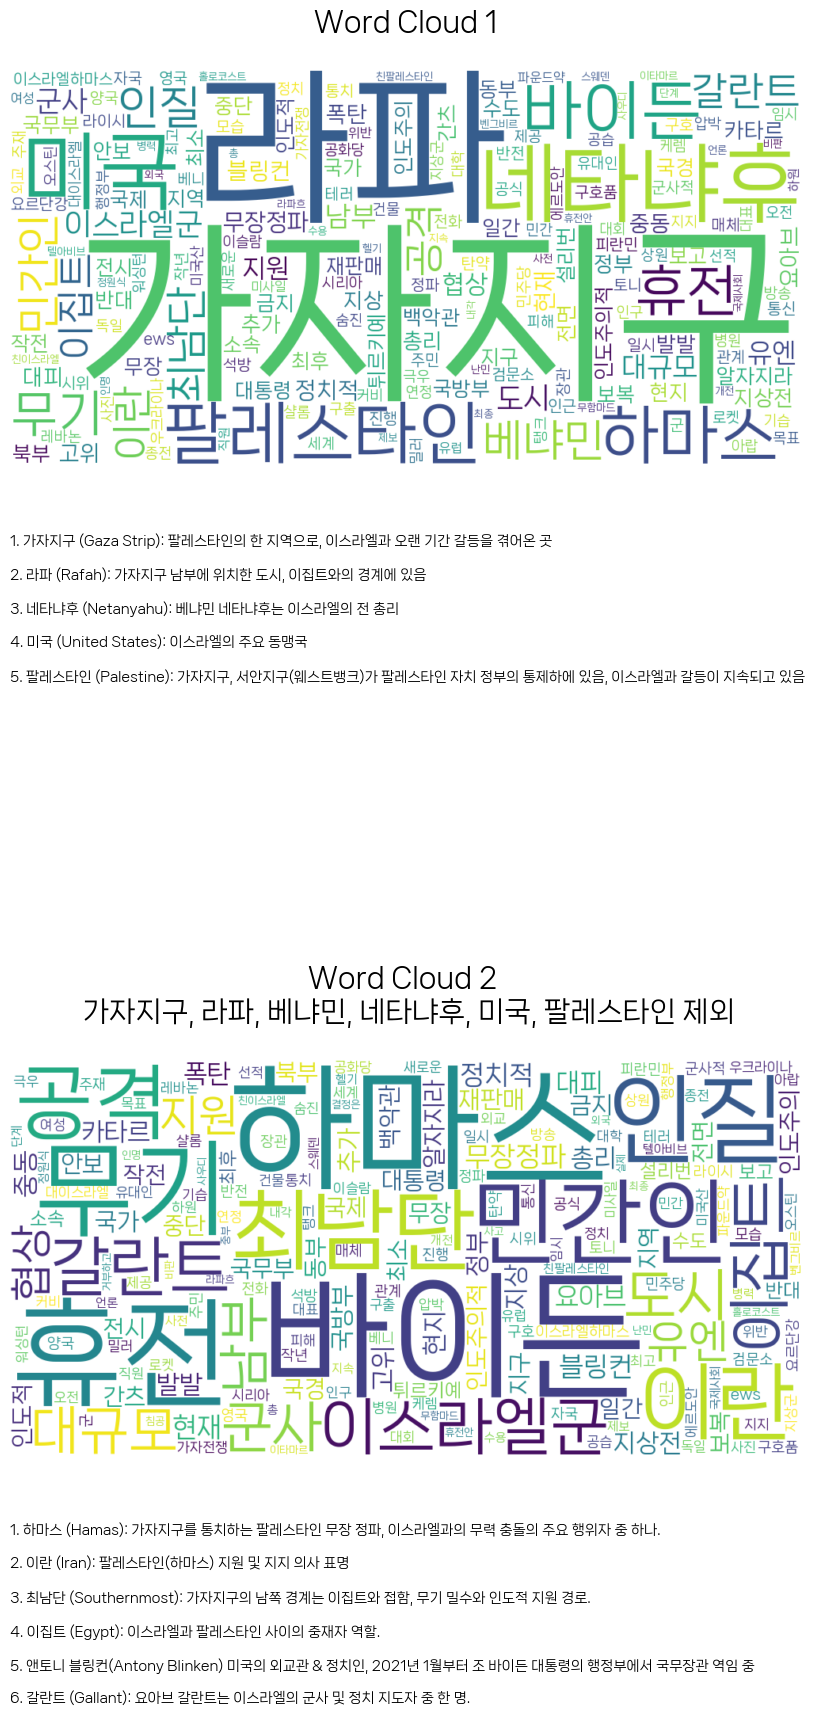

In [3]:
# 워드 클라우드: 이스라엘 전쟁

import re # 정규표현식 사용: 텍스트 데이터를 클렌징
import pandas as pd # 데이터 프레임 사용

import os # 파일의 존재 검사
from collections import Counter # 단어의 빈도수 계산

import nltk # 자연어 처리: 텍스트 토큰화를 위해 사용
from nltk.tokenize import word_tokenize # 텍스트 데이터를 단어 단위로 분할하기

import pickle # pickle 파일 로드

# 워드 클라우드
from wordcloud import WordCloud # 생성
import matplotlib.pyplot as plt # 시각화
from matplotlib import font_manager, rc # 폰트


# ________________________________________________________


# 불용어 사전 파일 경로
stopword_file_path1 = r"C:\Users\jkl12\Downloads\불용어 사전.txt"
stopword_file_path2 = r"C:\Users\jkl12\Downloads\불용어 사전2.txt"


# 불용어 사전 로드 함수
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        
        # 줄 단위로 나누기
        stopwords = file.read().splitlines()
    
    # 불용어 리스트를 집합(set)으로 변환하여 중복 제거
    return set(stopwords)

# 불용어 사전 호출 및 변수에 저장
custom_stopwords1 = load_stopwords(stopword_file_path1)
custom_stopwords2 = load_stopwords(stopword_file_path2)


# ___________________________________________________________

두 개의 불용어 사전 파일을 로드하여 불용어 목록을 만드는 과정을 수행합니다. 
# news_data3.pkl 파일 로드
with open("news_data3.pkl", "rb") as f:
    news_data = pickle.load(f)

    
# 뉴스 데이터에서 텍스트 추출
text_data = ' '.join(news_data['content'])


# 텍스트 클렌징
def clean_text(text):
    
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^a-z가-힣\s]', '', text)
    
    return text

# 클렌징된 텍스트 생성
cleaned_text = clean_text(text_data)


# _________________________________________________________



# NLTK 데이터 다운로드 (최초 1회 실행)
# 문장 분리 및 단어 토큰화를 위해 필요한 데이터
nltk.download('punkt')

# 토큰화: 단어 단위로 분할
tokens = word_tokenize(cleaned_text)


# 불용어 사전에 포함된 단어를 제외한 단어들만 남기기
# 빈도수 계산

filtered_tokens1 = [word for word in tokens if word not in custom_stopwords1]
word_counts1 = Counter(filtered_tokens1)

filtered_tokens2 = [word for word in tokens if word not in custom_stopwords2]
word_counts2 = Counter(filtered_tokens2)


# 나눔고딕 폰트 설정
font_path = r'C:\Users\jkl12\OneDrive\바탕 화면\내 파일\폰트\nanum-all\나눔 글꼴\나눔스퀘어네오\NanumSquareNeo-bRg.ttf'

# 폰트 설정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 워드 클라우드 생성
wordcloud1 = WordCloud(width=1000, height=500, background_color='white', font_path=font_path).generate_from_frequencies(word_counts1)
wordcloud2 = WordCloud(width=1000, height=500, background_color='white', font_path=font_path).generate_from_frequencies(word_counts2)

# 워드 클라우드 시각화
plt.figure(figsize=(12, 18))

# 첫 번째 워드 클라우드
plt.subplot(2, 1, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud 1\n', fontproperties=font_manager.FontProperties(fname=font_path, size=20))
plt.axis('off')
plt.text(0, -0.4, 
         '1. 가자지구 (Gaza Strip): 팔레스타인의 한 지역으로, 이스라엘과 오랜 기간 갈등을 겪어온 곳\n\n'
         '2. 라파 (Rafah): 가자지구 남부에 위치한 도시, 이집트와의 경계에 있음\n\n'
         '3. 네타냐후 (Netanyahu): 베냐민 네타냐후는 이스라엘의 전 총리\n\n' 
         '4. 미국 (United States): 이스라엘의 주요 동맹국\n\n'
         '5. 팔레스타인 (Palestine): 가자지구, 서안지구(웨스트뱅크)가 팔레스타인 자치 정부의 통제하에 있음, 이스라엘과 갈등이 지속되고 있음\n\n',
         ha='left', va='center', 
         transform=plt.gca().transAxes, fontsize=10, fontproperties=font_manager.FontProperties(fname=font_path))


# 두 번째 워드 클라우드
plt.subplot(2, 1, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Word Cloud 2 \n 가자지구, 라파, 베냐민, 네타냐후, 미국, 팔레스타인 제외\n', fontproperties=font_manager.FontProperties(fname=font_path, size=20))
plt.axis('off')
plt.text(0, -0.4, 
         '1. 하마스 (Hamas): 가자지구를 통치하는 팔레스타인 무장 정파, 이스라엘과의 무력 충돌의 주요 행위자 중 하나.\n\n'
         '2. 이란 (Iran): 팔레스타인(하마스) 지원 및 지지 의사 표명 \n\n'
         '3. 최남단 (Southernmost): 가자지구의 남쪽 경계는 이집트와 접함, 무기 밀수와 인도적 지원 경로.\n\n'
         '4. 이집트 (Egypt): 이스라엘과 팔레스타인 사이의 중재자 역할.\n\n'
         '5. 앤토니 블링컨(Antony Blinken) 미국의 외교관 & 정치인, 2021년 1월부터 조 바이든 대통령의 행정부에서 국무장관 역임 중 \n\n'
         '6. 갈란트 (Gallant): 요아브 갈란트는 이스라엘의 군사 및 정치 지도자 중 한 명.',
         ha='left', va='center', 
         transform=plt.gca().transAxes, fontsize=10, fontproperties=font_manager.FontProperties(fname=font_path))



# 두 워드 클라우드 간격 조정
plt.subplots_adjust(hspace=1.5)

plt.show()

In [49]:
# 이스라엘: 2023년 들어 하마스가 다소 잠잠해졌네. 뇌물 줘서 괜찮아 졌나보다ㅋㅋ

# 1. 서안 지구로 대부분의 병력을 배치 
# 2. 네타냐후: 자기 권력을 유지하느라 바쁨 
# 3. 사법개혁 반대 시위까지 겹치며, 혼란해짐 

# 2023년 10월 7일, 하마스
# 가자 지구에서 이스라엘 영내로 대규모 침공을 개시
# 2023년 이스라엘-하마스 전쟁

# ______________________________________________________________________________

# 가설 설정 후 인사이트 찾기
# 빈도수를 통해 어떤 텍스트가 가장 많이 나왔는가?
# 의미있는 해석이 가능할 때 (문서 구조 분석)

['NanumSquare Neo Regular']


findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not found.
findfont: Font family 'NanumSquare Neo Regular' not foun

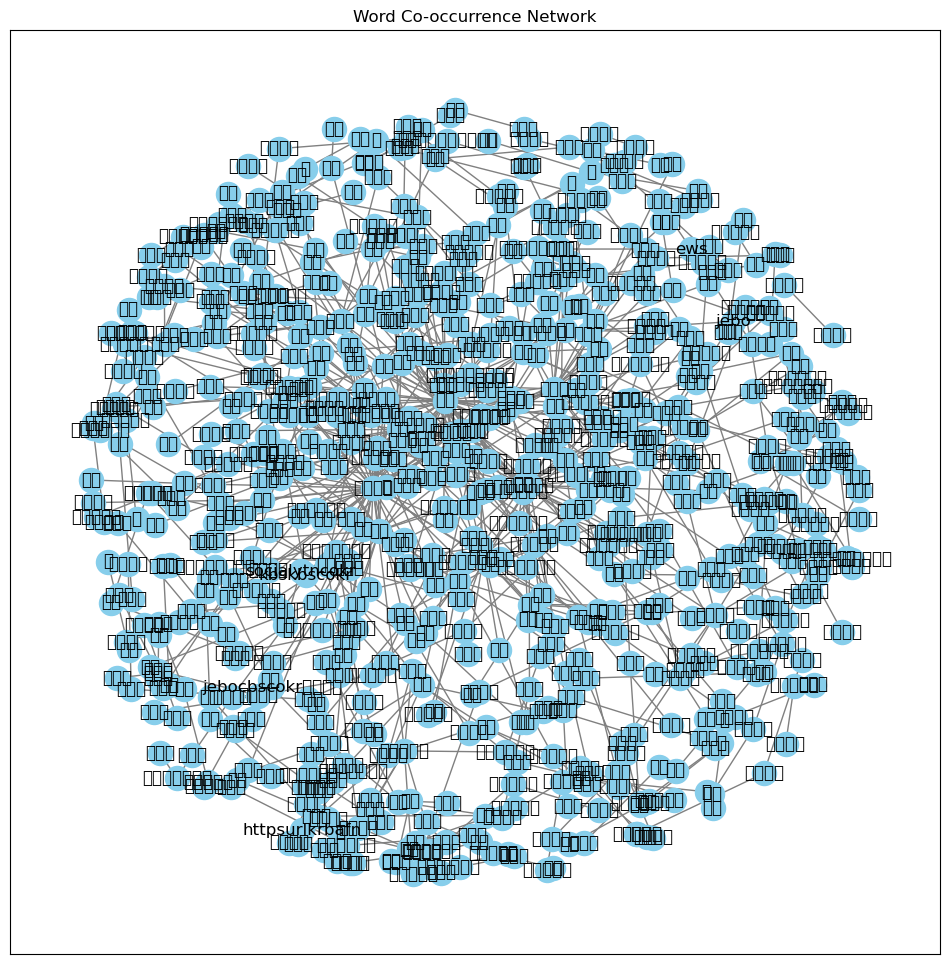

In [82]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# 현재 설정된 기본 폰트 확인
print(plt.rcParams['font.family'])

# 단어쌍의 빈도 계산 (공동 등장)
word_pairs = Counter(zip(filtered_tokens, filtered_tokens[1:]))

# 네트워크 그래프 생성
G = nx.Graph()

for (word1, word2), count in word_pairs.items():
    if count > 10:  # 임계값 설정
        G.add_edge(word1, word2, weight=count)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)

# 폰트 설정
font_path = r'C:\Users\jkl12\OneDrive\바탕 화면\내 파일\폰트\nanum-all\나눔 글꼴\나눔스퀘어네오\NanumSquareNeo-bRg.ttf'
font_prop = font_manager.FontProperties(fname=font_path)

nx.draw_networkx_nodes(G, pos, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_family=font_prop.get_name(), font_size=12)

plt.title('Word Co-occurrence Network')
plt.show()

In [39]:
# pip install tabulate

In [80]:
import matplotlib.pyplot as plt

# 현재 설정된 기본 폰트 확인
print(plt.rcParams['font.family'])


['NanumSquare Neo Regular']
